# Genetic diversity and population structure

## Setup

In [78]:
# Load packages
library(MASS)
library(tidyverse)

library(emmeans)
library(wesanderson)
library(gridExtra)
library(fs)
library(ggridges)
library(data.table)
library(RcppCNPy)
library(R.utils)
library(car)
library(ggrepel)
library(patchwork)


ERROR: Error in library(gridExtra): aucun package nommé ‘gridExtra’ n'est trouvé


## Load summary dataset

In [3]:
# Load in summary datasets rather than re-summarizing from raw data
obs_div_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_urban-rural_pi.txt.bz2', delim = '\t'))  # Observed urban-rural thetas
head(obs_div_df)
obs_fst_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_fst.txt.bz2', delim = '\t'))  # Observed urban-rural fst




city,habitat,tp_mean,tw_mean,tp_sd,tw_sd,taj,taj_sd,nSites
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Albuquerque,r,0.02698932,0.03200117,0.001375431,0.0010143774,-0.5396303,0.06615948,1014098
Albuquerque,u,0.02897677,0.03454662,0.001330479,0.0009070059,-0.5561956,0.07066635,805367
Antwerp,r,0.03431930,0.04283631,0.001813351,0.0014501993,-0.6826126,0.08142041,274252
Antwerp,u,0.02856077,0.03414765,0.001343769,0.0009041316,-0.5623712,0.06983064,925024
Armidale,r,0.02896160,0.03372373,0.001361144,0.0009864637,-0.4863528,0.06743949,966853
Armidale,u,0.03398263,0.04105213,0.003436243,0.0027046818,-0.5976881,0.13437001,162945


In [81]:
# Theme used for plotting
ng1 <- theme(panel.background = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border=element_blank(),
          axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(size = 1, color="black"),
          axis.ticks.length=unit(0.25, 'cm'),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=15),
          axis.text.y=element_text(size=15),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
          strip.background = element_rect(colour="black"),
          legend.position = "right", legend.direction="vertical",
          legend.text=element_text(size=17), legend.key = element_rect(fill = "white"),
          legend.title = element_text(size=17),legend.key.size = unit(1.0, "cm"))

ng2 <- theme(aspect.ratio=0.5,panel.background = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border=element_blank(),
          axis.line.x = element_line(color="black",size=1),
          axis.line.y = element_line(color="black",size=1),
          axis.ticks=element_line(size = 1, color="black"),
          axis.ticks.length=unit(0.25, 'cm'),
          axis.text=element_text(color="black",size=15),
          axis.title=element_text(color="black",size=1),
          axis.title.y=element_text(vjust=2,size=17),
          #axis.title.x=element_text(vjust=0.1,size=17),
          axis.text.x=element_text(size=15,angle = 45,hjust = 1),
          axis.text.y=element_text(size=15),
          strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
          strip.background = element_rect(colour="black"),
          axis.title.x=element_blank(),
          legend.position = "none")
          #legend.position = "right", legend.direction="vertical",
          #legend.text=element_text(size=17), legend.key = element_rect(fill = "white"),
          #legend.title = element_text(size=17),legend.key.size = unit(1.0, "cm"))



urban_col <- "#7b3294"
rural_col <- "#a6dba0"
cols <- c(urban_col, rural_col)

## Plot pi

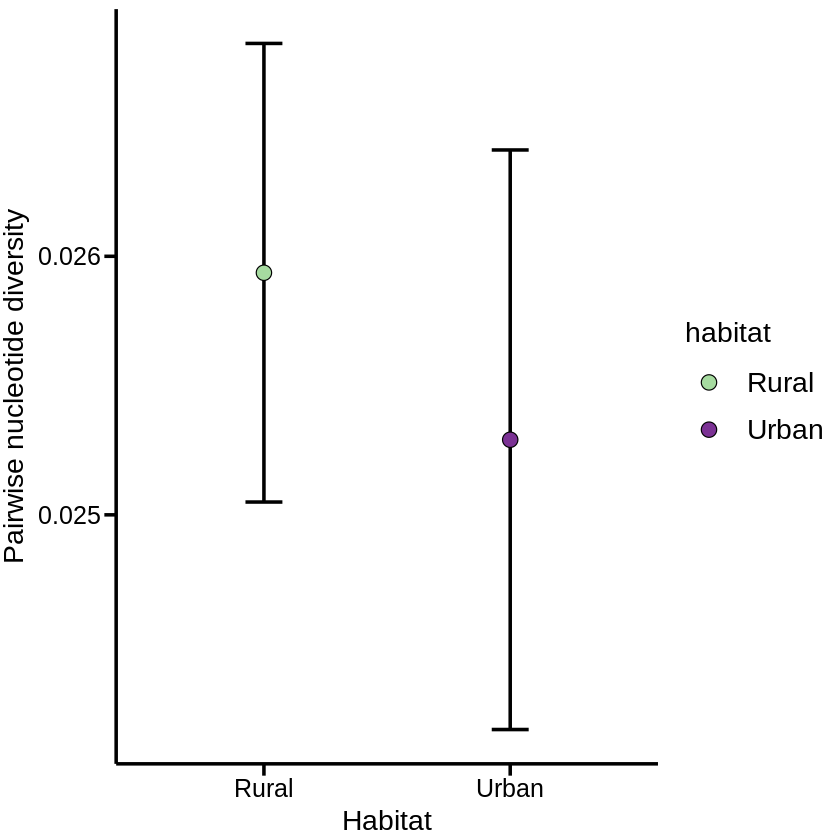

In [82]:
# Global pi
pi_by_habitat <- obs_div_df %>% 
    group_by(habitat) %>% 
    summarise(mean = mean(tp_mean),
              sd = sd(tp_mean),
              se = sd / sqrt(n())) %>% 
    mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
    ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
        geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.15, size = 1) +
        geom_point(size = 4, shape = 21) +
        scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
        ylab('Pairwise nucleotide diversity') + xlab('Habitat') +
    ng1
pi_by_habitat


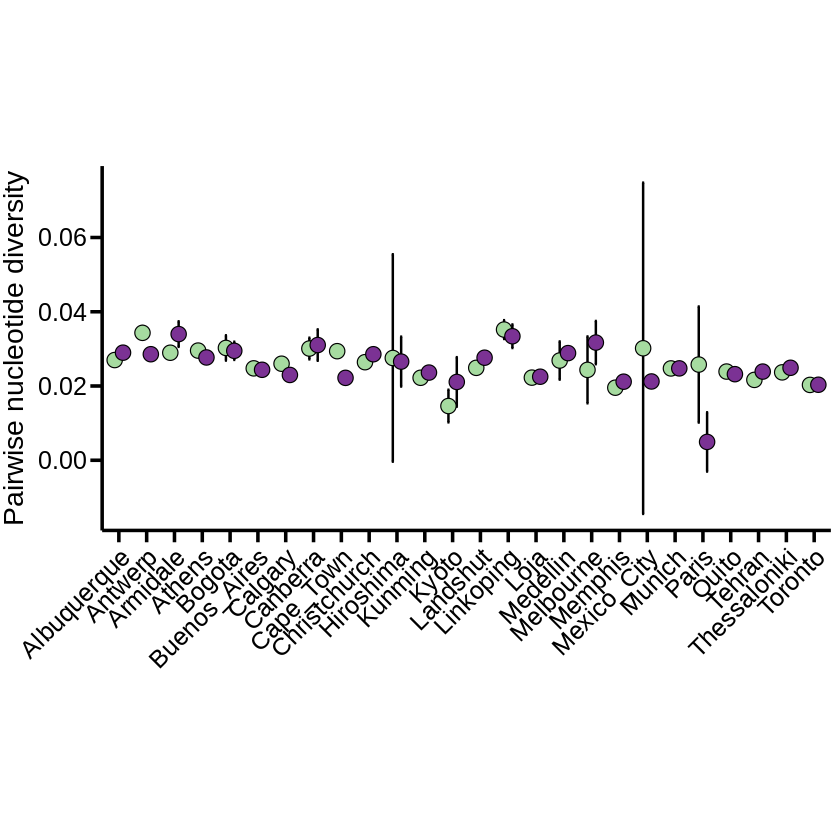

In [83]:
# Pi per city per habitat
pi_by_city_by_habitat <- obs_div_df %>% 
    mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
    ggplot(., aes(x = city, y = tp_mean, fill = habitat)) +
        geom_errorbar(aes(ymax = tp_mean + tp_sd, ymin = tp_mean - tp_sd), width = 0.15, size = .7, position=position_dodge(width = 0.6)) +
        geom_point(size = 4, shape = 21, position=position_dodge(width = 0.6)) +
        scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
        ylab('Pairwise nucleotide diversity') +
    ng2
pi_by_city_by_habitat




In [ ]:
## Plot Watterson's theta

In [ ]:
## Plot Tajima's D

In [ ]:
## Plot Fst

# Generate summary datasets

Note: This section only needs to be run to generate the summary datasets from the raw data output by the Snakemake pipeline. If the Snakemake pipeline hasn't been run, then the manuscript's results can be reproduced by running the analyses above using the summary datasets.

## Functions used to generate summary datasets

In [25]:
# Function to load observed diversity estimates by city and habitat
load_obs_pairwise_diversity <- function(path){
    
    # Get city and site names from file
    city <- dirname(path)
    site <- str_extract(basename(path), pattern = '(?<=_)[r|u]')
    
    full_path <- paste0(inpath, path)
    
    # Load dataframe
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               habitat = site) %>% 

    # Calculate mean across chromosomes and sum of number of sites
        group_by(city, habitat) %>% 
        summarise(tp_mean = mean(tp_scaled),
                  tw_mean = mean(tw_scaled),
                  tp_sd = sd(tp_scaled,na.rm=TRUE),
                  tw_sd = sd(tw_scaled, na.rm=TRUE),
                  taj= mean(Tajima),
                  taj_sd = sd(Tajima),
                  nSites = sum(nSites),
                 .groups = 'drop') %>% 
        dplyr::select(city, habitat, tp_mean, tw_mean, tp_sd, tw_sd, taj, taj_sd, nSites)

    return(df)
    
}


# Function to load observed Fst df by city/habitat
load_obs_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(path)
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(city = city)
    
    return(df)
    
}

# Function to load permuted Fst df by city/habitat
load_perm_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(dirname(path))
    seed <- str_extract(basename(path), pattern = '(?<=_seed)\\d+')
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(city = city,
               seed = seed)
    
    return(df)
    
}

# Function to load admixture results from PCAngsd
load_admixture <- function(path){
    
    city <- basename(dirname(path))
    bam_list_path <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/program_resources/bam_lists/by_city/withoutRelated/'
    samples <- suppressMessages(list.files(paste0(bam_list_path, city, '/'), 
                          pattern = '*lowCovRemoved*', 
                          full.names = TRUE) %>% 
        read_table(., col_names = FALSE)) %>% 
        mutate(sample = str_extract(X1, '(?<=\\/)\\w+_\\d+_\\d+(?=_4fold)')) %>% 
        pull(sample)
    
    df <- npyLoad(path) %>% 
        as_tibble() %>% 
        mutate(city = city,
               sample = samples)
    return(df)
}

## Write dataframes

### Urban-rural genetic diversity

In [26]:
# Concatenate urban and rural genetic diversity results (N = 2 habitats x 26 citis = 52) into single dataframe
inpath <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/'
obs_div_df <- list.files(inpath, pattern = '.*_[u|r]_4fold.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_obs_pairwise_diversity)
head(obs_div_df)

# Write observed data to disc
write_delim(obs_div_df, '../analyses/tables/div_popStruct/observed_urban-rural_pi.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/observed_urban-rural_pi.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

city,habitat,tp_mean,tw_mean,tp_sd,tw_sd,taj,taj_sd,nSites
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Albuquerque,r,0.02698932,0.03200117,0.001375431,0.0010143774,-0.5396303,0.06615948,1014098
Albuquerque,u,0.02897677,0.03454662,0.001330479,0.0009070059,-0.5561956,0.07066635,805367
Antwerp,r,0.03431930,0.04283631,0.001813351,0.0014501993,-0.6826126,0.08142041,274252
Antwerp,u,0.02856077,0.03414765,0.001343769,0.0009041316,-0.5623712,0.06983064,925024
Armidale,r,0.02896160,0.03372373,0.001361144,0.0009864637,-0.4863528,0.06743949,966853
Armidale,u,0.03398263,0.04105213,0.003436243,0.0027046818,-0.5976881,0.13437001,162945


### Urban-rural Fst

In [3]:
# Merge Fst dataframes. Using Hudson's Fst
inpath <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/hudson_fst/'
obs_fst_df <- list.files(inpath, pattern = '.*_4fold_r_u_readable.fst', recursive = TRUE) %>% 
    map_dfr(., load_obs_fst)

# Write observed Fst values to disc
write_delim(obs_fst_df, '../analyses/tables/div_popStruct/observed_fst.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/observed_fst.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

## Admixture

In [44]:
inpath <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/population_structure/pcangsd/by_city/pcangsd_withoutRelated/'
ss <- suppressMessages(
    read_delim(
        '../resources/glue_pc_sampleSheet_noRelated.txt', 
                           delim = '\t')) %>% 
    dplyr::select(site, sample)

admix_df <- list.files(inpath, pattern = '*.Q.npy', recursive = TRUE, full.names = TRUE) %>% 
    map_dfr(., load_admixture) %>% 
    left_join(., ss, by = 'sample') %>% 
    pivot_longer(V1:V2, values_to = 'Probs')

# Write admixture dataframe to disc
write_delim(admix_df, '../analyses/tables/div_popStruct/admixture.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/admixture.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

site,sample
<chr>,<chr>
r,Albuquerque_29_5
r,Albuquerque_29_9
r,Albuquerque_32_13
r,Albuquerque_32_3
r,Albuquerque_33_2
r,Albuquerque_33_7


In [45]:
# Write summary datasets to disc so analyses can be reproduced without running the pipeline
# This only needs to be run once and datasets with be git controlled and placed in data repositories
write_csv(obs_div_df, '../analyses/tables/observed_urban-rural_pi.csv')
#write_csv(perm_div_df, '../analyses/tables/permuted_urban-rural_pi.csv')
write_csv(obs_fst_df, '../analyses/tables/observed_fst.csv')
#write_csv(perm_fst_df, '../analyses/tables/permuted_fst.csv')